# Neural ODE for mnist classification



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [2]:
%matplotlib notebook

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

def animate_frames(frames: torch.Tensor, draw_func=None):
    if draw_func is None:
        def draw_func(ax, t, frames):
            ax.cla()
            ax.imshow(frames[t])
            ax.set_title(str(t))
    fig, ax = plt.subplots()
    f = lambda t: draw_func(ax, t % len(frames), frames)
    return FuncAnimation(fig, func=f, frames=len(frames))

In [3]:
class Node(nn.Module):
    """ Neural ode with i/o. """
    class Func(nn.Module):
        def __init__(self, d):
            super(Node.Func, self).__init__()
            self.fc1 = nn.Linear(2*d, 2*d)
            self.fc2 = nn.Linear(2*d, d)
    
        def forward(self, t, x):
            x = torch.concat(x, dim=1)
            x = F.softplus(self.fc1(x))
            return self.fc2(x)

    def __init__(self, c, h, w, d_out):
        super(Node, self).__init__()
        self.dim = c * h * w
        self.dxdt = Node.Func(self.dim)
        self.fc_out = nn.Linear(self.dim, d_out)

    def forward(self, inp, init_cond=None, t_eval=None, return_trajectories=False, rtol=1, atol=1, method='rk4'):
        B, C, H, W = inp.shape
        
        if init_cond is None:
            state = torch.randn(B, self.dim)
        else:
            assert inp.shape == init_cond.shape
            state = init_cond
            
        if t_eval is None:
            t_eval = torch.Tensor([0, 1])
            
        dxdt = lambda t, state: self.dxdt(t, (inp.view(B, -1), state))
        trajectories = odeint(dxdt, state, t=t_eval, rtol=rtol, atol=atol, method=method)
        state = trajectories[-1]
        out = self.fc_out(state)
        if return_trajectories:
            return out, trajectories.reshape(len(t_eval), B, C, H, W)
        return out

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader) = 94


 33%|█████████████████████████████████████████████████▎                                                                                                  | 1/3 [00:08<00:17,  8.64s/it]

Epoch [1/3], Loss: 1.4277


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2/3 [00:17<00:08,  8.61s/it]

Epoch [2/3], Loss: 0.3515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.57s/it]

Epoch [3/3], Loss: 0.2446


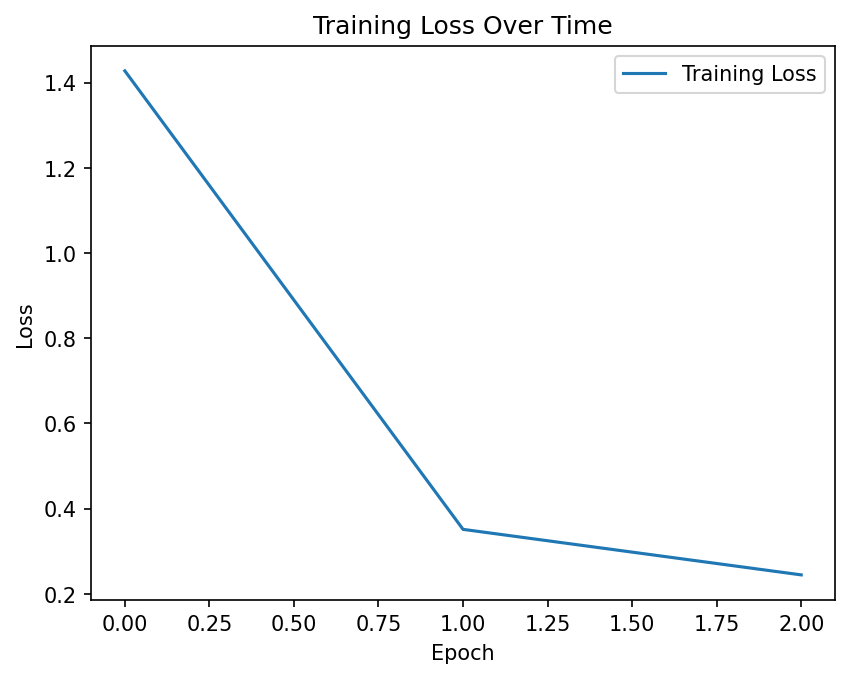

In [5]:
import time

model = Node(1, 28, 28, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
train_losses = []

print('len(train_loader) =', len(train_loader))

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for nt, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

%matplotlib inline
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [6]:
data = [(x, y) for x, y in iter(train_loader)]

In [7]:
x, y = data[0]
logits = model(x)
probs = torch.softmax(logits, dim=-1)
preds = torch.argmax(probs, dim=-1)

print((torch.sum(preds == y) / len(y)).item())

0.94921875


torch.Size([1880, 2])


Text(0, 0.5, 'model accuracy')

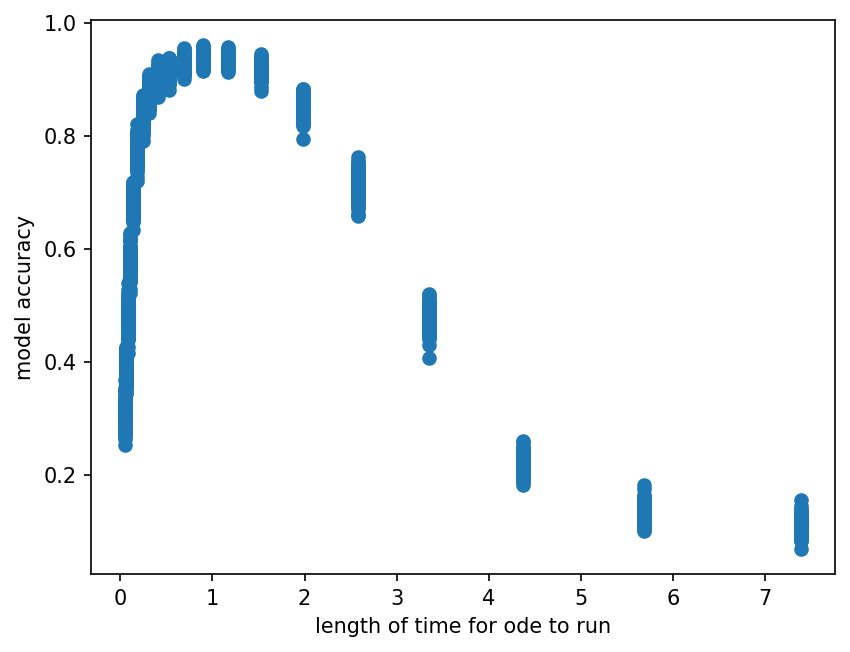

In [8]:
## vary t_eval
endtime_vs_accuracy = []
for end_time in torch.linspace(-3, 2, 20):
    end_time = torch.exp(end_time)
    for d in data:
        x, y = d
        logits = model(x, t_eval=torch.linspace(0, end_time, 2))
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        accuracy = (torch.sum(preds == y) / len(y)).item()
        endtime_vs_accuracy.append([end_time, accuracy])

eva = torch.Tensor(endtime_vs_accuracy)
print(eva.shape)
plt.scatter(eva[:, 0], eva[:, 1])
plt.xlabel('length of time for ode to run')
plt.ylabel('model accuracy')

In [9]:
logits, trajectories = model(x, t_eval=torch.linspace(0, 20, 100), return_trajectories=True)
trajectories = trajectories.detach()

In [10]:
trajectories.shape

torch.Size([100, 384, 1, 28, 28])

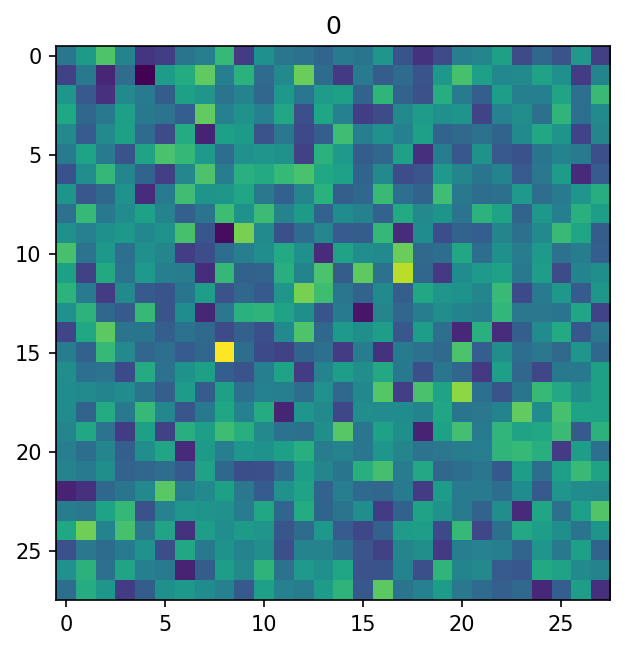

In [12]:
# print(trajectories[:, 0, :].squeeze(1).shape)
animate_frames(trajectories[:, 0, :].squeeze(1))